### Описание задачи:
Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание данных:
Данные состоят из файлов, полученных из разных источников:
* data_arc.csv — данные об электродах;
* data_bulk.csv — данные о подаче сыпучих материалов (объём);
* data_bulk_time.csv — данные о подаче сыпучих материалов (время);
* data_gas.csv — данные о продувке сплава газом;
* data_temp.csv — результаты измерения температуры;
* data_wire.csv — данные о проволочных материалах (объём);
* data_wire_time.csv — данные о проволочных материалах (время).<br>

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

Разработка прототипа модели машинного обучения будет состоять из нескольких этапов:
- Составьте план работы. Исходное условие задачи заведомо неполное и содержит лишнюю информацию. Проведите исследовательский анализ данных, чтобы понять, какие вопросы подготовить.
- Уточните задачу. Задайте вопросы тимлиду в ходе онлайн-встречи.
- Разработайте модель. Отправьте код на проверку ревьюверу.
- Подготовьте отчёт. Отправьте отчёт тимлиду, чтобы он проверил успешность выполнения задания.

### Условия задачи:

Целевой признак: последняя измеренная температура в каждой партии.<br>

Метрика: MAE<br>

Критерии оценки:
- MAE > 8.7 — 0 sp
- 7.6 < MAE ≤ 8.7 — 4 sp
- 6.8 < MAE ≤ 7.6 — 4.5 sp
- 6.3 < MAE ≤ 6.8 — 5 sp
- 6.0 < MAE ≤ 6.3 — 5.5 sp
- MAE ≤ 6.0 — 6 sp

Для успешной сдачи выпускного проета необходимо набрать 5 SP. <br>

В качестве признаков можно использовать первую измеренную температуру и все остальные факторы в любой момент времени.

In [3]:
import pandas as pd
import numpy as np
import os
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
PATH = './datasets/final/'

In [5]:
SEED = 42

Загрузка данных

In [6]:
arc = pd.read_csv(PATH + 'data_arc.csv')
bulk = pd.read_csv(PATH + 'data_bulk.csv')
bulk_time = pd.read_csv(PATH + 'data_bulk_time.csv')
gas = pd.read_csv(PATH + 'data_gas.csv')
temp = pd.read_csv(PATH + 'data_temp.csv')
wire = pd.read_csv(PATH + 'data_wire.csv')
wire_time = pd.read_csv(PATH + 'data_wire_time.csv')

### 1) Исследовательский анализ данных

#### Данные об электродах

In [7]:
arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [8]:
arc.sample(random_state=SEED)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
12925,2808,2019-08-17 08:37:28,2019-08-17 08:38:34,0.22182,0.226526


In [9]:
arc.tail()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708


In [10]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Пропусков нет

In [11]:
arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Отрицательное значение в столбце Реактивная мощность. Возможно, аномальное значение из-за ошибки измерения

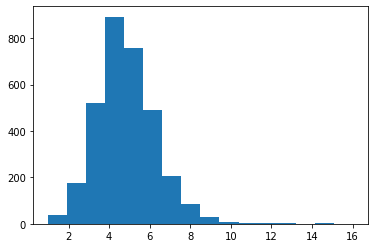

In [13]:
plt.hist((list(arc['key'].value_counts())), bins=16)
plt.show()

Столбец `key` содержит номер партии. Количество итераций обработки различается для каждой партии от 1 до 16. Мода - 4 итерации. 

#### Данные о подаче сыпучих материалов (объём)

In [14]:
bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [15]:
bulk.sample(random_state=SEED)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2754,2857,NaN,NaN,NaN,108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.0,NaN,198.0,108.0


In [16]:
bulk.tail()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


In [17]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Большое количество пропусков, есть столбцы, где почти все значения пропущены. Думаю, это объясняется особенностями технологического процесса - для каждой партии добавляют опредленное сочетание сыпучих материалов. Поэтому пропуски можно заполнить 0.

In [19]:
bulk['key'].value_counts().unique()

array([1], dtype=int64)

Каждой партии соответствует только одна строка.

In [20]:
keys = list(bulk['key'])
no_value = []
for i in list(range(1, 3242)):
    if i not in keys:
        no_value.append(i)
len(no_value)

112

Нет данных о 112 партиях

#### Данные о подаче сыпучих материалов (время)

In [22]:
bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [23]:
bulk_time.tail()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 04:05:34,2019-09-01 04:05:34


In [24]:
bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Аналогичные пропуски, как и в прошлом датасете.

#### Данные о проволочных материалах (объём)

In [39]:
wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
wire.tail()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Механизм пропусков аналогичен пропускам в данных о сыпучих материалах

#### Данные о проволочных материалах (время)

In [42]:
wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
wire_time.tail()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-01 04:16:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Аналогичные пропуски, как в данных о подаче сыпучих материалов

#### Данные о продувке сплава газом

In [25]:
gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [26]:
gas.sample(random_state=SEED)

,key,Газ 1
844,847,8.635693


In [27]:
gas.tail()

,key,Газ 1
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


In [28]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Пропусков нет

In [29]:
keys = list(gas['key'])
no_value_gas = []
for i in list(range(1, 3242)):
    if i not in keys:
        no_value_gas.append(i)
no_value_gas

[193, 259]

Отсутствуют данные для двух партий 

#### Результаты измерения температуры

In [30]:
temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [31]:
temp.sample(random_state=SEED)

,key,Время замера,Температура
3355,659,2019-05-27 16:33:01,1602.0


In [32]:
temp.tail(15)

,key,Время замера,Температура
15892,3239,2019-09-01 02:23:02,NaN
15893,3239,2019-09-01 02:24:15,NaN
15894,3240,2019-09-01 02:39:01,1617.0
15895,3240,2019-09-01 02:48:33,NaN
15896,3240,2019-09-01 03:03:21,NaN
15897,3240,2019-09-01 03:12:19,NaN
15898,3240,2019-09-01 03:19:09,NaN
15899,3240,2019-09-01 03:31:27,NaN
15900,3240,2019-09-01 03:34:31,NaN
15901,3240,2019-09-01 03:35:16,NaN


In [33]:
temp[temp['Температура'].isnull()].head()

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN


In [34]:
temp[temp['Температура'].isnull()].tail()

,key,Время замера,Температура
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


Начиная с партии 2500, пропущенны все значения температуры, кроме первого измерения

In [35]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


Всего около 20% пропусков в столбце Температура

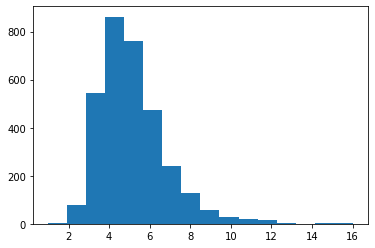

In [36]:
plt.hist((list(temp['key'].value_counts())), bins=16)
plt.show()

Количество итераций обработки различается для каждой партии от 1 до 16. Мода - 4 итерации.

In [37]:
temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [38]:
keys = list(temp['key'])
no_value_temp = []
for i in list(range(1, 3242)):
    if i not in keys:
        no_value_temp.append(i)
len(no_value_temp)

25

Нет данных для 25 партий

### Примерный план решения задачи:
1) Обработка пропусков - в данных о подаче сыпучих и проволочных материалов много пропусков. Нужно подумать, как их обработать и будут ли эти данные полезны. В данных с целевым признаком тоже значительное количество пропусков<br>
2) Объединение данных в один датасет - возможен вариант объединения на основе очищенных от пропусков данных с целевым признаком<br>
3) Преобразование признаков - изменение типа данных в столбцах, создание новых(например, общее время нагрева и доли мощности)<br>
4) Cоздание обучающей, валидационной и тестовой выборок<br>
5) Создание и тестирование моделей - выбор лучшей модели

### 2) Предобработка данных

Я решил отказаться от использования данных о времени подачи сыпучих материалов и проволоки из-за незначительного воздействия этих признаков на целевой признак.

На этапе исследования данных мы выяснили, что с партии 2500 значения температуры есть только для первого измерения. Поэтому оставим только партии до номера 2499 включительно

In [119]:
temp = temp.query('key < 2500')

Количество итераций в каждой партии

In [120]:
temp['key'].value_counts()

1513    16
46      16
44      16
1214    16
1689    15
        ..
1973     2
1836     2
1210     2
279      1
195      1
Name: key, Length: 2477, dtype: int64

В двух партиях только одно измерение температуры, значит мы не сможем использовать эти данные. Потому что нам нужно минимум два значения - первое и последнее(для целевого признака)

Удаляю строки с партиями 195 и 279

In [121]:
temp = temp.query('key not in (195, 279)')

Проверяю наличие этих партий в других датасетах

In [122]:
arc[arc['key']==279]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность


In [123]:
arc[arc['key']==195]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность


In [124]:
gas[gas['key']==279]

,key,Газ 1
276,279,7.232359


In [125]:
gas[gas['key']==195]

,key,Газ 1
193,195,0.374436


Удаляю партии 195 и 279 из данных о продувке газом

In [126]:
gas = gas.query('key not in (195, 279)')

В данных о подаче материалов выбираю признаки с менее чем 30 объектами

In [127]:
bulk_col = ['Bulk 2', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 13']

In [128]:
wire_col = ['Wire 4', 'Wire 5', 'Wire 7', 'Wire 8', 'Wire 9']

Удаляю их

In [129]:
bulk = bulk.drop(bulk_col, axis=1)
wire = wire.drop(wire_col, axis=1)

В данных о подаче сыпучих материалов и проволоки удаляю лишние партии. Пропуски заполняю 0, так как на этапе исследования мы выяснили, что пропуски соответствуют отсутствию материала.

In [130]:
bulk = bulk.query('key not in (195, 279) and key < 2500').fillna(0)
wire = wire.query('key not in (195, 279) and key < 2500').fillna(0)

На этапе исследования мы также обнаружили отрицательное значение реактивной мощности, что вероятнее всего является ошибкой. Поэтому удаляем эти данные

In [131]:
arc = arc[arc['Реактивная мощность'] > 0]

Создаю целевой признак - последняя измеренная температура в каждой партии

Меняю тип данных в столбце `Время замера` на `datetime`

In [132]:
temp['Время замера'] = pd.to_datetime(temp['Время замера'])

Время последнего измерения для каждой партии

In [133]:
last = pd.to_datetime(temp.groupby('key')['Время замера'].max())

Датафрейм с временем последнего измерения и значением температуры в каждой партии

In [134]:
temp_target = temp.merge(last, on="Время замера") \
                         .rename(columns={"Время замера": "last_check", "Температура": "last_temp"})

In [135]:
temp_target.shape

(2475, 3)

In [136]:
temp_target.head()

,key,last_check,last_temp
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:36:01,1602.0


Время первого измерения для каждой партии

In [137]:
first = pd.to_datetime(temp.groupby('key')['Время замера'].min())

Датафрейм с временем первого измерения и значением температуры в каждой партии

In [138]:
temp_first = temp.merge(first, on="Время замера") \
                         .rename(columns={"Время замера": "first_check", "Температура": "first_temp"})

In [139]:
temp_first.head()

,key,first_check,first_temp
0,1,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:37:27,1581.0
2,3,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:23:19,1576.0


Создаю датафрейм с количеством итераций в каждой партии

In [140]:
count = arc.query('key < 2500')['key'].value_counts().sort_index() \
                              .reset_index().rename(columns={"index": "key", "key": "count"})

In [141]:
count.head()

,key,count
0,1,5
1,2,4
2,3,5
3,4,4
4,5,4


In [142]:
count.shape

(2475, 2)

Создаю датафрейм с суммой активных и реактивных мощностей, использованных для нагрева, в каждой партии

In [143]:
power_sum = arc.query('key < 2500').groupby('key')['Активная мощность', 'Реактивная мощность'].sum() \
                                   .reset_index() \
                                   .rename(columns={"Активная мощность": "active_power",
                                                    "Реактивная мощность": "reactive_power"})
power_sum.head()

,key,active_power,reactive_power
0,1,4.878147,3.183241
1,2,3.052598,1.998112
2,3,2.525882,1.599076
3,4,3.209250,2.060298
4,5,3.347173,2.252643


Создание датафрейма с началом первого нагрева дугой, окончанием последнего нагрева и общим временем нагрева для каждой партии

Изменение типа данных на `datetime`

In [144]:
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'])
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'])

Начало первого нагрева дугой и окончание последнего нагрева для каждой партии 

In [145]:
start = pd.to_datetime(arc.groupby('key')['Начало нагрева дугой'].min()).reset_index()
stop = pd.to_datetime(arc.groupby('key')['Конец нагрева дугой'].max()).reset_index()

Создаю новый признак `sum` с длительностью нагрева в секундах для каждой итерации

In [146]:
arc['sum'] = (arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']) // pd.Timedelta('1s')

Группирую данные по значению `key`, суммирую значения длительности нагрева

In [147]:
arc_group = arc.query('key < 2500').groupby('key')['sum'].sum().reset_index()

In [148]:
arc_group.head()

,key,sum
0,1,1098
1,2,811
2,3,655
3,4,741
4,5,869


Объединяю данные с признаками `start` и `stop` - значения начала первого нагрева дугой и окончания последнего нагрева 

In [149]:
arc_group = arc_group.merge(start, on='key')
arc_group = arc_group.merge(stop, on='key')

In [150]:
arc_group = arc_group.rename(columns={"Начало нагрева дугой": "start", "Конец нагрева дугой": "stop"})

In [151]:
arc_group.head()

,key,sum,start,stop
0,1,1098,2019-05-03 11:02:14,2019-05-03 11:28:37
1,2,811,2019-05-03 11:34:14,2019-05-03 11:53:18
2,3,655,2019-05-03 12:06:54,2019-05-03 12:32:19
3,4,741,2019-05-03 12:39:37,2019-05-03 12:57:50
4,5,869,2019-05-03 13:11:13,2019-05-03 13:33:55


In [152]:
arc_group.shape

(2475, 4)

Удаляю лишние партии из данных о продувке сплава газом

In [153]:
gas = gas.query('key < 2500').rename(columns={"Газ 1": "gas"})
gas.head()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


### 2) Объединение данных в один датасет

Объединяю данные о продувке газа, время последнего измерения температуры и целевой признак

In [154]:
df = gas.merge(temp_target, on='key')

In [155]:
df.head()

,key,gas,last_check,last_temp
0,1,29.749986,2019-05-03 11:30:39,1613.0
1,2,12.555561,2019-05-03 11:59:12,1602.0
2,3,28.554793,2019-05-03 12:34:57,1599.0
3,4,18.841219,2019-05-03 12:59:25,1625.0
4,5,5.413692,2019-05-03 13:36:01,1602.0


Добавляю данные с количеством итераций в каждой партии

In [156]:
df = df.merge(count, on='key')

In [157]:
df.head()

,key,gas,last_check,last_temp,count
0,1,29.749986,2019-05-03 11:30:39,1613.0,5
1,2,12.555561,2019-05-03 11:59:12,1602.0,4
2,3,28.554793,2019-05-03 12:34:57,1599.0,5
3,4,18.841219,2019-05-03 12:59:25,1625.0,4
4,5,5.413692,2019-05-03 13:36:01,1602.0,4


Добавляю данные с суммарной активной и реактивной мощностями

In [158]:
df = df.merge(power_sum, on='key')

In [159]:
df.head()

,key,gas,last_check,last_temp,count,active_power,reactive_power
0,1,29.749986,2019-05-03 11:30:39,1613.0,5,4.878147,3.183241
1,2,12.555561,2019-05-03 11:59:12,1602.0,4,3.052598,1.998112
2,3,28.554793,2019-05-03 12:34:57,1599.0,5,2.525882,1.599076
3,4,18.841219,2019-05-03 12:59:25,1625.0,4,3.209250,2.060298
4,5,5.413692,2019-05-03 13:36:01,1602.0,4,3.347173,2.252643


Добавляю данные с временем начала первого нагрева дугой, окончанием последнего нагрева и общим временем нагрева для каждой партии

In [160]:
df = df.merge(arc_group, on='key')

In [161]:
df.head()

,key,gas,last_check,last_temp,count,active_power,reactive_power,sum,start,stop
0,1,29.749986,2019-05-03 11:30:39,1613.0,5,4.878147,3.183241,1098,2019-05-03 11:02:14,2019-05-03 11:28:37
1,2,12.555561,2019-05-03 11:59:12,1602.0,4,3.052598,1.998112,811,2019-05-03 11:34:14,2019-05-03 11:53:18
2,3,28.554793,2019-05-03 12:34:57,1599.0,5,2.525882,1.599076,655,2019-05-03 12:06:54,2019-05-03 12:32:19
3,4,18.841219,2019-05-03 12:59:25,1625.0,4,3.209250,2.060298,741,2019-05-03 12:39:37,2019-05-03 12:57:50
4,5,5.413692,2019-05-03 13:36:01,1602.0,4,3.347173,2.252643,869,2019-05-03 13:11:13,2019-05-03 13:33:55


Добавляю данные с временем первого измерения и значениями температуры

In [162]:
df = df.merge(temp_first, on='key')

Добавляю данные о подачи сыпучих материалов и проволоки

In [163]:
df = df.merge(bulk, on='key')
df = df.merge(wire, on='key')

Создаю признак `power_ratio` c соотношением активной и реактивной мощностей

In [164]:
df['power_ratio'] = df['reactive_power'] / df['active_power']

Создаю признаки с длительностью времени от начала нагрева дугой в секундах

In [165]:
df['delta1'] = (df['first_check'] - df['start']) // pd.Timedelta('1s')
df['delta2'] = (df['stop'] - df['start']) // pd.Timedelta('1s')
df['delta3'] = (df['last_check'] - df['start']) // pd.Timedelta('1s')

Удаляю признаки с временем

In [166]:
time_columns = ['start', 'stop', 'first_check', 'last_check']

In [167]:
df = df.drop(time_columns, axis=1)

In [168]:
df.shape

(2329, 26)

### 3) Обучение и тестирование моделей

Создаю обучающую и тестовую выборки в соотношении 80:20

In [169]:
X = df.drop('last_temp', axis=1)
y = df['last_temp']

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Скалирую данные

In [171]:
sc = StandardScaler().fit(X_train)
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)

Подбор гиперпараметров с кросс-валидацией на 5 подвыборках

In [172]:
kf = KFold(n_splits=5, shuffle=False)

#### Линейная регрессия

In [173]:
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
grid_lr = GridSearchCV(LinearRegression(), parameters, cv=kf, scoring='neg_mean_absolute_error')
grid_lr.fit(X_train_scaled, y_train)
params = grid_lr.best_params_
print('MAE на кросс-валидации: ', abs(grid_lr.best_score_))
lr = LinearRegression(**params)
lr.fit(X_train_scaled, y_train)
pred_test = lr.predict(X_test_scaled)
print(params)
print("MAE на тестовой выборке: ", mean_absolute_error(y_test, pred_test))

MAE на кросс-валидации:  6.4524153066125365
{'fit_intercept': True, 'normalize': False}
MAE на тестовой выборке:  6.057346691391726


#### Случайный лес

Для `RandomForestRegressor` поиск будет осуществляться по гиперпараметрам `max_depth`, `min_samples_split`. Создаю переменную `tree_params` c различными вариантами значений указанных гиперпараметров.

In [174]:
tree_params = {'n_estimators': [500], 
               'max_depth': [2, 4, 6],
               'min_samples_split': [2, 5, 8, 10]}

In [175]:
grid_rfr = GridSearchCV(RandomForestRegressor(random_state=SEED), 
                        tree_params, refit=False, cv=5, scoring='neg_mean_absolute_error') 
grid_rfr.fit(X_train_scaled, y_train)
print('MAE на кросс-валидации: ', abs(grid_rfr.best_score_))
params = grid_rfr.best_params_
rfr = RandomForestRegressor(**params, random_state=SEED)
rfr.fit(X_train_scaled, y_train)
pred_test = rfr.predict(X_test_scaled)
print(params)
print("MAE на тестовой выборке: ", mean_absolute_error(y_test, pred_test))

MAE на кросс-валидации:  6.2324753455516735
{'max_depth': 6, 'min_samples_split': 5, 'n_estimators': 500}
MAE на тестовой выборке:  5.992450716362696


#### Градиентный бустинг

Для `LGBMRegressor` поиск будет осуществляться по гиперпараметрам `learning_rate` и `max_depth`. Создаю переменную `param_grid` c различными вариантами значений указанных гиперпараметров.

In [177]:
param_grid = {'n_estimators': [500], 
              'learning_rate': [0.03, 0.1, 0.2],
              'max_depth': [4, 6]}

In [178]:
grid_lgbm = GridSearchCV(lgb.LGBMRegressor(random_state=SEED), 
                    param_grid, cv=5, scoring='neg_mean_absolute_error', refit=False) 
grid_lgbm.fit(X_train_scaled, y_train)
print('MAE на кросс-валидации: ', abs(grid_lgbm.best_score_))
params = grid_lgbm.best_params_
lgbm = lgb.LGBMRegressor(**params, random_state=SEED)
lgbm.fit(X_train_scaled, y_train)
pred_test = lgbm.predict(X_test_scaled)
print(params)
print("MAE на тестовой выборке: ", mean_absolute_error(y_test, pred_test))

MAE на кросс-валидации:  5.679126416245969
{'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 500}
MAE на тестовой выборке:  5.498923188498681


Для `CatBoostRegressor` поиск будет осуществляться по гиперпараметрам `learning_rate` и `depth`. Создаю переменную `param_grid_ctb` c различными вариантами значений указанных гиперпараметров

In [179]:
param_grid_ctb = {'n_estimators': [500],  
                  'learning_rate': [0.03, 0.1, 0.2],
                  'depth': [4, 6]}

In [180]:
grid_ctb = GridSearchCV(CatBoostRegressor(random_state=SEED, silent=True), 
                    param_grid_ctb, cv=5, scoring='neg_mean_absolute_error', refit=False) 
grid_ctb.fit(X_train_scaled, y_train)
print('MAE на кросс-валидации: ', abs(grid_ctb.best_score_))
params = grid_ctb.best_params_
ctb = CatBoostRegressor(**params, random_state=SEED, silent=True)
ctb.fit(X_train_scaled, y_train)
pred_test = ctb.predict(X_test_scaled)
print(params)
print("MAE на тестовой выборке: ", mean_absolute_error(y_test, pred_test))

MAE на кросс-валидации:  5.5845987987864145
{'depth': 6, 'learning_rate': 0.03, 'n_estimators': 500}
MAE на тестовой выборке:  5.3344065456028575


#### Выводы:
- На этапе предобработки данных были удалены отрицательные значения реактивной мощности, строки с партиями 195 и 279. Для обучения и тестирования моделей использовались данные партий до номера 2499 включительно. В данных о подаче сыпучих материалов и проволоки пропуски заменены 0.
- На тестовой выборке лучший результат MAE у модели `CatBoostRegressor` 5.3, чуть хуже `LGBMRegressor` - 5.5. `RandomForestRegressor` и`LinearRegression` показали MAE около 6.
- Гиперпараметры лучшей модели `CatBoostRegressor` - {'depth': 6, 'learning_rate': 0.03, 'n_estimators': 500}

### Отчёт:

#### Какие пункты плана были выполнены, а какие — нет (поясните почему)?

Первоначальный план выглядел так:<br>
1) Обработка пропусков - в данных о подаче сыпучих и проволочных материалов много пропусков. Нужно подумать, как их обработать и будут ли эти данные полезны. В данных с целевым признаком тоже значительное количество пропусков<br>
2) Объединение данных в один датасет - возможен вариант объединения на основе очищенных от пропусков данных с целевым признаком<br>
3) Преобразование признаков - изменение типа данных в столбцах, создание новых(например, общее время нагрева и доли мощности)<br>
4) Выбор метрики - перед нами задача регрессии, поэтому можно использовать RMSE. Она будет сильнее штрафовать за ошибки и хорошо интерпретируется<br>
5) Cоздание обучающей, валидационной и тестовой выборок<br>
6) Создание и тестирование моделей - выбор лучшей модели

- Все основные пункты плана были выполнены. 
- Метрика MAE была определена заказчиком.
- Не было отдельной валидационной выборки, потому что в процессе подбора гиперпараметров осуществлялась кросс-валидации на 5 подвыборках

#### Какие трудности возникли и как вы их преодолели?

- Были некоторые трудности в понимании технологического процесса и природы данных, но они разрешились после поверхностного изучения домена и общения с тимлидом.

#### Какие ключевые шаги в решении задачи выделили?

1) Исследование данных<br>
2) Предобработка данных<br>
3) Объединение всех нужных данных в один датасет<br>
4) Подбор гиперпараметров для разных моделей и их тестирование

#### Какая ваша итоговая модель и какое у неё качество?

- Обучены четыре модели. Результаты MAE на тестовой выборке: CatBoostRegressor - `5.3`, LGBMRegressor - `5.5`, RandomForestRegressor - `6`, LinearRegression - `6.1`
- Исходя из лучшего сочетания MAE, скорости обучения и предсказания, выбрана модель CatBoostRegressor с гиперпараметрами {'depth': 6, 'learning_rate': 0.03, 'n_estimators': 500}


#### Датасет

- Итоговый датасет состоит из 26 признаков и 2329 строк.
- Обучающая и тестовая выборка в соотношении 80:20 - 1863 и 466 строк
- 15 признаков основаны на данных о продувке газом, подаче сыпучих материалов и проволки. 
- 4 признака основаны на времени начала и окончания нагрева электродами и измерениями температуры
- 3 признака основаны на данных активной и реактивной мощности
- 2 признака основаны на данных о номере партии и количестве итераций нагрева
- 1 признак - первая измеренная температура в партии
- 1 целевой признак - последняя измеренная температура в партии

#### Графики

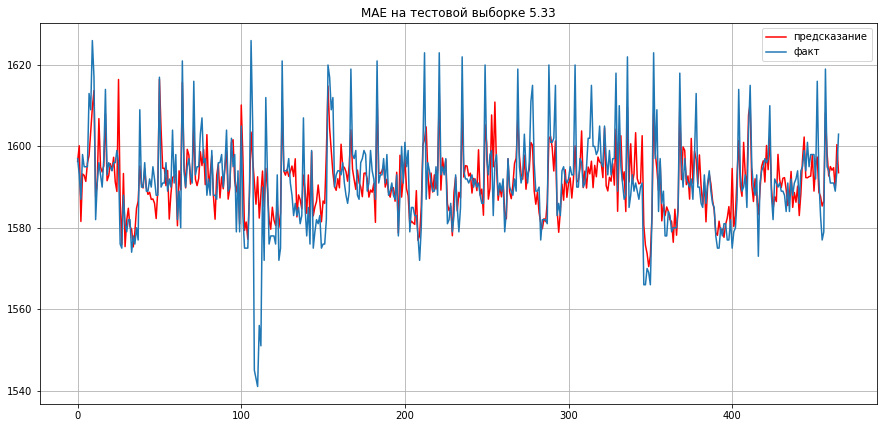

In [193]:
plt.figure(figsize=(15, 7))
plt.plot(pred_test, "r", label="предсказание")
plt.plot(y_test.values, label="факт")
plt.legend(loc="best")
plt.title("MAE на тестовой выборке {}".format(round(mean_absolute_error(pred_test, y_test), 1)))
plt.grid(True);

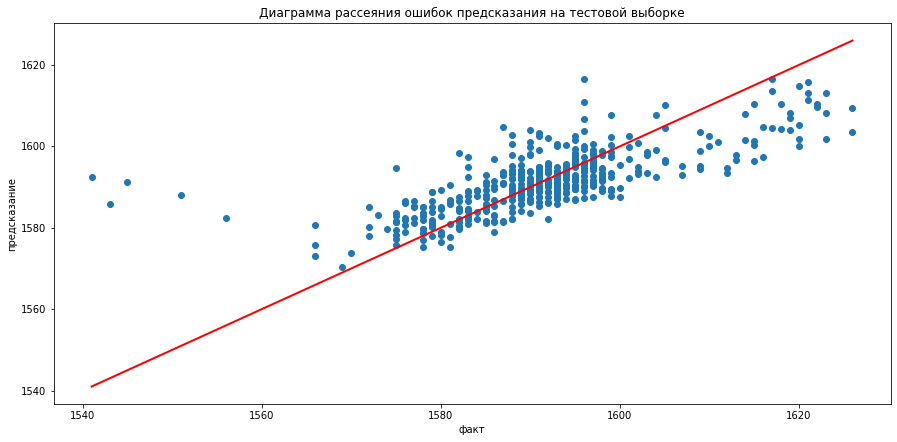

In [207]:
y = y_test.values
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(y, pred_test)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r', lw=2)
ax.set_xlabel('факт')
ax.set_ylabel('предсказание')
ax.set_title('Диаграмма рассеяния ошибок предсказания на тестовой выборке')
plt.show()